In [320]:
import numpy as np
import astropy.units as u
import matplotlib.pylab as plt
import matplotlib.cm as cm
from astropy.time import Time
import astropy.units as u
from pulsar.predictor import Polyco
from scipy.stats import binned_statistic
import glob
%matplotlib inline
pfont = {'fontname':'Helvetica'}
figures = 0
figdir = '/home/ramain/packages/b1957GiantPulses'

In [110]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def dechannelize(pulse):
    pulse = np.fft.irfft(pulse, axis=1)
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, pulse.shape[-1])
    else:
        pulse = pulse.ravel()
    return pulse

def correlate(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine / abs(p1fine)) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_power(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def wfilter(p2, p1, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)

    # Hardcoded, which is unfortunate
    #SN = (abs(p1fine[32])- abs(p1fine[:20]).mean(axis=0)) / abs(p1fine)[:20].std(axis=0)
    SN = abs(p1fine[0])
    SN[SN < 0.01] = 0.01
    H = p1fine / abs(p1fine)
    G = (1 / H) * ( abs(H)**2.0 / (abs(H)**2.0 + (1/SN[np.newaxis,:])) )
    Y = p2fine

    x = rechannelize(G * Y, cchan)
    return x

def power(dchan):
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    power = (abs(dR)**2 + abs(dL)**2)
    return power

def powerchan(dchan):
    R = np.array([8,0,10,2,12,4,14,6])
    L = np.array([9,1,11,2,13,5,15,7])
    dR = dchan[...,R]
    dL = dchan[...,L]
    power = abs(dR)**2.0 + abs(dL)**2.0
    return power

def normpower(pulse):
    p1temp = rechannelize(pulse, 256)
    power1 = abs(p1temp)**2.0
    power1 = power1[16] - power1[2:12].mean(axis=0)
    power1 = power1[32:-32]
    power1 = (power1 - power1.mean(axis=0)) / power1.std(axis=0)
    return power1

def Stokes(R,L):
    I = abs(R)**2.0 + abs(L)**2.0
    Q = 2*np.real(np.conj(L)*R)
    U = -2*np.imag(np.conj(L)*R)
    V = abs(R)**2.0 - abs(L)**2.0
    return I, Q, U, V

def channelize_ts(pulse, nchan):
    if len(pulse.shape) == 2:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def pad(ts,nzeros):
    ts = np.concatenate((ts,0*ts[:nzeros]), axis=0)
    return ts
    
def rechanIm(pulse, nchan):
    pulse = np.fft.ifft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:  
        pol = pulse.shape[-1]
    else:
        pol = 1
    
    pulse = pulse.reshape(-1,pol)
    zero_padding = nchan - pulse.shape[0] % nchan
    
    print(pulse.shape, nchan, zero_padding)
    
    if zero_padding > 0:
        pulse = pad(pulse,zero_padding)

    pulse = pulse.reshape(-1, nchan, pol)
    pulse = np.fft.fft(pulse, axis=1)
    
    return pulse

In [3]:
"""
Load all b1957 Pulses
"""

b1957GPs = np.loadtxt('/media/drive2/b1957-GPs/gp_RCP.txt', dtype='string')
                      
bT = Time(b1957GPs[:,0], precision=5)
bSN = b1957GPs[:,1].astype('float')
bphase = b1957GPs[:,2].astype('float')

SNcut = 6
bT = bT[bSN > SNcut]
bphase = bphase[bSN > SNcut]
bSN = bSN[bSN > SNcut]

#bSN = bSN[abs(bphase-0.8) < 0.1 ]
#bT = bT[abs(bphase-0.8) < 0.1 ]
#bphase = bphase[abs(bphase-0.8) < 0.1 ]


"""
Take only first two days for simpicity (i.e. ignore weirdness at eclipse)
"""

#bphase = bphase[bT < Time('2014-06-13T07:30:00')]
#bSN = bSN[bT < Time('2014-06-13T07:30:00')]
#bT = bT[bT < Time('2014-06-13T07:30:00')]

bphase = bphase[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bSN = bSN[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bT = bT[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]

#print bT

#Tphase = bT

bdT = bT.unix - np.roll(bT.unix, 1)
bsort = np.argsort(bdT)
#bdT[bsort]

/usr/local/lib/python2.7/dist-packages/astropy/table/column.py:331: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return super(BaseColumn, self).__getitem__(item)


2014-06-13T05:38:37.48054


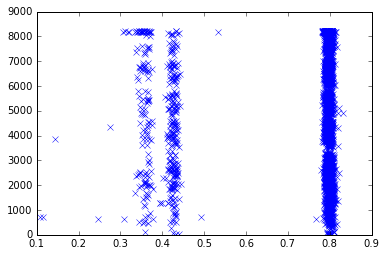

In [4]:
"""
Re-Calculate Phases with Alex's corrected polyco
"""

psr_polyco = Polyco('/home/ramain/packages/scint_analysis/b1957_GPs/polycob1957+20_ao.dat')
#psr_polyco = Polyco('/home/ramain/trials/b1957/polycob1957+20_ao.dat')
#psr_polyco = Polyco('/home/ramain/Ephemerides/polycob1957+20_ao.dat')

phase_pol = psr_polyco.phasepol(bT[0])

pt = []
for i in range(len(bT)):
    time = bT[i]
    phase_pol = psr_polyco.phasepol(time)
    bphase[i] = np.remainder(phase_pol(time.mjd), 1)

bphase = np.remainder(bphase+0.82, 1)
plt.plot(bphase[:3600], (bT.unix - bT[0].unix)[:3600], 'bx')
#plt.plot(bphase[:10], (bT.unix - bT[0].unix)[:10], 'bx')
#plt.xlim(0.77, 0.83)

print bT[3]

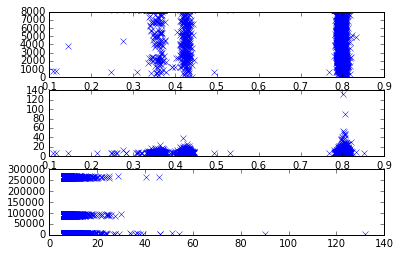

In [5]:
%matplotlib inline
plt.subplot(311)
plt.plot(bphase, bT.unix - bT[0].unix, 'bx')
plt.ylim(0,8000)

plt.subplot(312)
plt.plot(bphase, bSN, 'bx')

plt.subplot(313)
plt.plot(bSN, bT.unix - bT[0].unix, 'bx')

323.247226517 0.0222574592082


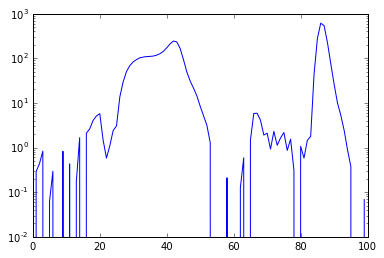

In [6]:
"""
Load Folded Profile
"""

foldSN = np.load('/media/drive2/b1957-GPs/folded/b1957_SNprofile.npy')

# Mean and sigma in log space as a functions of phase - i.e. log-normal PDF for each phase bin
foldsig = np.load('/media/drive2/b1957-GPs/folded/sigma.npy')
foldmean = np.load('/media/drive2/b1957-GPs/folded/mean.npy')

foldSN_binned = foldSN.reshape(100,10).mean(-1) * np.sqrt(10)

bg = np.concatenate((foldmean[52:65],foldmean[0:15]))
norm_mean = (10**(bg)).mean()
norm_sig = (10**(bg)).std()
print norm_mean, norm_sig
profile = 10**(foldmean)
profile = (profile - norm_mean) / norm_sig

sig_one = 10**(foldmean + 1*foldsig)
sig_one = (sig_one - norm_mean) / norm_sig
sig_three = 10**(foldmean + 3*foldsig)
sig_three = (sig_three - norm_mean) / norm_sig
sig_five = 10**(foldmean + 6*foldsig)
sig_five = (sig_five - norm_mean) / norm_sig

#sig_contour = 10**(np.log10(SNforcont) + 10*foldsig)

#SNforcont = 1.*foldSN_binned
        
#sig_contour = 10**(np.log10(SNforcont) + 10*foldsig)
coarse_bins = np.linspace(0,1,100)

#plt.subplot(211)
plt.plot(profile)
#plt.plot(sigcont)
#plt.plot(10**foldmean)
#plt.subplot(212)
#plt.plot(foldSN_binned)
#plt.plot(sig_contour)

plt.yscale('log')

#npulses = 16125419 # (2.4hours * 3 / pulse period)
npulses = 335320*15*3


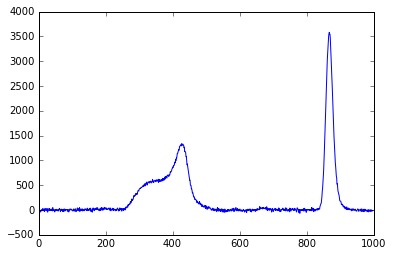

In [7]:
foldFlux = np.load('/media/drive2/b1957-GPs/folded/NORMED-B1957IQV-a-04-b23-1000g-273-100x.npy')
plt.plot(foldFlux.sum(0))

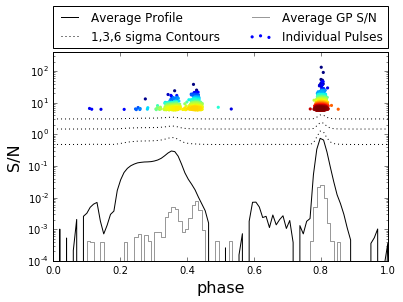

In [8]:
"""
FIGURE 1 A
"""
from scipy.stats import binned_statistic
from scipy.stats import gaussian_kde


#GPhist = binned_statistic(bphase, bSN, statistic='sum', bins = GPbins)[0]
#GPhist2 = binned_statistic(bphase, bSN, statistic='count', bins = GPbins)[0]
#plt.plot(GPbins[:-1], GPhist / np.sqrt(GPhist2), 'ko-', markersize=1, label='Summed GP S/N')

xy = np.vstack([bphase,bSN])
z = np.log10(gaussian_kde(xy)(xy))

idx = z.argsort()
x, y, z = bphase[idx], bSN[idx], z[idx]

plt.scatter(x, y, c=z, s=10, edgecolor='', label='Individual Pulses')
#plt.plot(bphase, bSN, 'ko', markersize=0.2, label='Individual Pulses')
#plt.plot(np.roll(coarse_bins,7), foldSN_binned, color='0', label='Average Profile')
#plt.plot(np.roll(coarse_bins,7), sig_contour, 'k--', color='0', label='??? Contour')

'''
average pulse SN is integrated / sqrt(Npulses)
sqrt(2) comes from only one pol being used?
Incoherent shift to align the pulses, with Nikhil's different Fref 
(checked that this indeed lines them up)
'''
plt.plot(np.roll(coarse_bins,7), profile/np.sqrt(335320*2), 'k', label='Average Profile')
plt.plot(coarse_bins, np.roll(sig_one,-7)/np.sqrt(335320*2), 'k:', color='0', label='1,3,6 sigma Contours')
plt.plot(coarse_bins, np.roll(sig_three,-7)/np.sqrt(335320*2), 'k:', color='0')
plt.plot(coarse_bins, np.roll(sig_five,-7)/np.sqrt(335320*2), 'k:', color='0')

# Add average integrated Pulse emission
GPhist = binned_statistic(bphase, np.sqrt(bSN), statistic='sum', bins = coarse_bins)[0]

histplot = np.sqrt(GPhist)
histplot[np.isnan(histplot)] = 1.e-5
histplot[histplot==0] = 1.e-5

plt.plot(coarse_bins[1:], histplot/np.sqrt(npulses), color='0.6', label='Average GP S/N', drawstyle='steps')

#plt.plot(np.roll(GPbins,70), np.sqrt(5)*foldSN, color='0', label='Average Profile')

plt.ylabel('S/N', fontsize=16)
plt.xlabel('phase', fontsize=16)
plt.xlim(0,1)
plt.ylim(1e-4, 400)
plt.yscale('log')
#plt.legend()
plt.subplots_adjust(top=0.85)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/fig1a.pdf', dpi=500)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


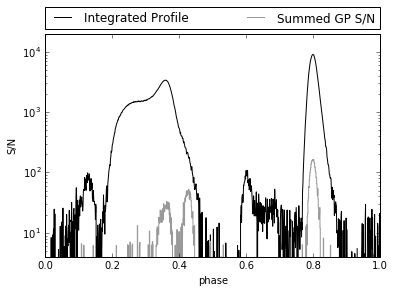

In [9]:
"""
FIGURE 1 B
"""
from scipy.stats import binned_statistic

#plt.plot(bphase, bSN, 'kx')

GPbins = np.linspace(0,1,1000)

GPhist = binned_statistic(bphase, bSN, statistic='sum', bins = GPbins)[0]
GPhist2 = binned_statistic(bphase, bSN, statistic='count', bins = GPbins)[0]

histplot = GPhist / np.sqrt(GPhist2)
histplot[np.isnan(histplot)] = 1

plt.plot(np.roll(GPbins,70), np.sqrt(5)*foldSN * np.sqrt(npulses), color='0', label='Integrated Profile')
plt.plot(GPbins[:-1], histplot, color='0.6', label='Summed GP S/N', drawstyle='steps')

plt.ylabel('S/N')
plt.xlabel('phase')
plt.xlim(0,1)
plt.ylim(4, 2e4)
plt.yscale('log')#, nonposy='clip')

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

if figures:
    plt.savefig('fig1b.pdf')

ERROR: NameError: name 'MPtypical' is not defined [IPython.core.interactiveshell]


NameError: name 'MPtypical' is not defined

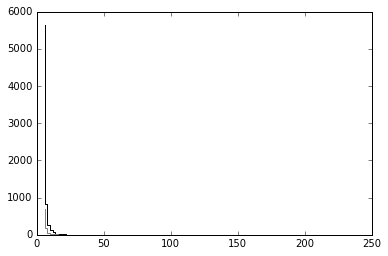

In [10]:
"""
Create PDF of Pulse Brightness

FIGURE 1C
"""

#SNbins = np.logspace(np.log10(6),np.log10(max(bSN)), 30)
SNbins = np.linspace(6,206, 101)

MPSN = bSN[abs(bphase-0.8) < 0.1 ]
IPSN = bSN[abs(bphase-0.38) < 0.1 ]

MPhist = np.histogram(MPSN, bins=SNbins)[0]
IPhist = np.histogram(IPSN, bins=SNbins)[0]
    
plt.plot(SNbins[:-1], MPhist+1e-5, drawstyle='steps', label='Main Pulse', color = '0.0')
plt.plot(SNbins[:-1], IPhist+1e-5, drawstyle='steps', label='Interpulse', color = '0.5')

plt.plot(np.sqrt(5)*MPtypical, npulses, 'kx')
plt.plot(np.sqrt(5)*IPtypical, npulses, '+', color = '0.5')

plt.yscale('log')
plt.xscale('log')
plt.ylim(0.1,2*npulses)
plt.xlim(IPtypical/2,150)
plt.legend()
plt.xlabel( 'S/N' )
plt.ylabel('N pulses')
if figures:
    plt.savefig('fig1c.pdf')

In [11]:
"""
Look at Polarization Profile of Brightest Pulses
"""

GP_Tlist = Time(['2014-06-13T06:01:21.91125', '2014-06-13T06:01:23.83364', 
                 '2014-06-13T06:06:35.94089'], precision=5)

pad = np.zeros((100,1))

for t_gp in GP_Tlist:

    GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
    GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))

    GPR = np.concatenate((GPR,pad), axis=-1)
    GPL = np.concatenate((GPL,pad), axis=-1)

    GPR = rechannelize(GPR, 48)[750:900]
    GPL = rechannelize(GPL, 48)[750:900]

    I, Q, U, V = Stokes(GPR, GPL)

    L = Q + 1j*U

    plt.plot(I.sum(1) - I.sum(1)[:40].mean(0), 'k', label='I')
    plt.plot(abs(L).sum(1) - abs(L).sum(1)[:40].mean(0), 'r', label='|L|')
    plt.plot(V.sum(1) - V.sum(1)[:40].mean(0), 'b', label='V')
    plt.legend()
    
    plt.xlabel('Time [microseconds]')
    plt.ylabel('Intensity')
    
    if figures:
        plt.savefig('b1957_GP%s.pdf' % (t_gp.isot))
    plt.clf()

In [314]:
"""
Profile of Brightest Pulse

Calculation of scattering time from exponential fit
"""

GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))
GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))

GPR = np.concatenate((GPR,pad), axis=-1)
GPL = np.concatenate((GPL,pad), axis=-1)

GPR = rechannelize(GPR, 48)[750:910]
GPL = rechannelize(GPL, 48)[750:910]

I, Q, U, V = Stokes(GPR, GPL)

Iscattering = I.sum(1) - I.sum(1)[:40].mean(0)
Is_fit = np.log(Iscattering[60:110])
t_fit = np.linspace(0, 50, 51)[:-1]
bfit = np.polyfit(t_fit, Is_fit, 1)

t_plot = np.linspace(0, 100, 101)[:-1]
t_Is = np.linspace(-60, 100, 161)[:-1]
model = bfit[0]*t_plot + bfit[1]

print("ts = %s" % (1 / bfit[0]))

print Iscattering.shape

plt.plot(t_Is+6, Iscattering, 'k', label='I')
plt.plot(t_plot+6, np.exp(model), 'r--', label = 'model')
plt.xlim(-50, 100)
plt.xlabel(r't [$\mu$s]', fontsize=16)
plt.ylabel('Intensity [arbitrary]', fontsize=16, **pfont)
plt.legend()

if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/ScatteringTail.pdf')

ERROR: ValueError: all the input arrays must have same number of dimensions [IPython.core.interactiveshell]


ValueError: all the input arrays must have same number of dimensions

ts = -12.2088526955
(160,)


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


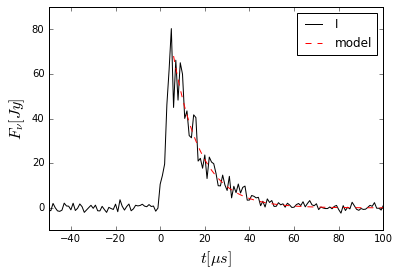

In [321]:
"""
Profile of Brightest Pulse

Calculation of scattering time from exponential fit
"""

GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))
GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % ('2014-06-13T07:00:02.13597'))

GPR = np.concatenate((GPR,nyq_pad), axis=-1)
GPL = np.concatenate((GPL,nyq_pad), axis=-1)

GPR = rechannelize(GPR, 48)[750:910]
GPL = rechannelize(GPL, 48)[750:910]

I, Q, U, V = Stokes(GPR, GPL)

Iscattering = (I.sum(1) / I.sum(1)[:40].mean(0) - 1) * 12
Is_fit = np.log(Iscattering[60:110])
t_fit = np.linspace(0, 50, 51)[:-1]
bfit = np.polyfit(t_fit, Is_fit, 1)

L = Q + 1j*U
Ls = (abs(L).sum(1) / abs(I).sum(1)[:40].mean(0) - 1) * 12
Vs = (V.sum(1) / I.sum(1)[:40].mean(0)) * 12

t_plot = np.linspace(0, 100, 101)[:-1]
t_Is = np.linspace(-60, 100, 161)[:-1]
model = bfit[0]*t_plot + bfit[1]

print("ts = %s" % (1 / bfit[0]))

print Iscattering.shape

plt.plot(t_Is+6, Iscattering, 'k', label='I')
#plt.plot(t_Is+6, Ls, 'r', label='|L|')
#plt.plot(t_Is+6, Vs, 'b', label='V')
#plt.plot(t_Is+6, np.sqrt(Ls_bg**2.0+Vs**2.0), 'b', label='I')


plt.plot(t_plot+6, np.exp(model), 'r--', label = 'model')
plt.xlim(-50, 100)
plt.xlabel(r'$t [\mu s]$', fontsize=16,**pfont)
plt.ylabel(r'$F_{\nu} [Jy]$', fontsize=16)
plt.legend()

figures = 0
if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/ScatteringTail.pdf')

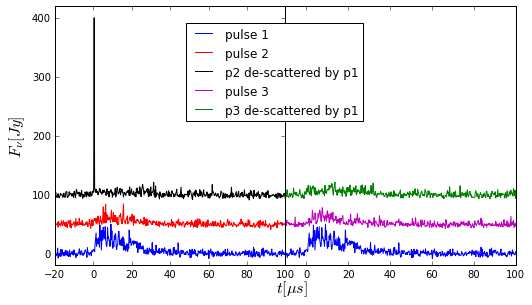

In [329]:
'''
FIGURE 4 - The moneyplot!

De-Scatter the 2s bright pair
'''

import matplotlib.lines as mlines

t_ref = Time('2014-06-13T06:01:21.91125', precision=5)
t_p = Time('2014-06-13T06:01:23.83364', precision=5)
t_p3 = Time('2014-06-13T06:06:35.94089', precision=5)
pad = np.zeros((100,1))

Tsys = 12 # (120K, gain = 10K / Jansky)

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_ref.isot))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_p.isot))
p3 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_p3.isot))

p1 = np.concatenate((p1,pad), axis=-1)
p2 = np.concatenate((p2,pad), axis=-1)
p3 = np.concatenate((p3,pad), axis=-1)

p1temp = rechannelize(p1, 3*16)
p2temp = rechannelize(p2, 3*16)
p3temp = rechannelize(p3, 3*16)

p1temp = np.roll(p1temp, 1037-np.argmax(abs(p1temp).sum(-1)), axis=0)
p2temp = np.roll(p2temp, 1039-np.argmax(abs(p2temp).sum(-1)), axis=0)
p3temp = np.roll(p3temp, 1031-np.argmax(abs(p3temp).sum(-1)), axis=0)

corr = correlate_power(p2temp, p1temp, 4*3, 512*3)
corr13 = correlate_power(p3temp, p1temp, 4*3, 512*3)
p1prof = rechannelize(p1temp, 4*3)
p2prof = rechannelize(p2temp, 4*3)
p3prof = rechannelize(p3temp, 4*3)

# Turn into Flux units using gain = 10K / Jy, Tsys = 120K

p1flux = (abs(p1prof)**2.0).sum(-1)
p1flux = (p1flux /p1flux[:500].mean() - 1) * 12
p2flux = (abs(p2prof)**2.0).sum(-1)
p2flux = (p2flux /p2flux[:500].mean() - 1) * 12
p3flux = (abs(p3prof)**2.0).sum(-1)
p3flux = (p3flux /p3flux[:500].mean() - 1) * 12
c1flux = (abs(corr)**2.0).sum(-1)
c1flux = (c1flux /c1flux[:500].mean() - 1) * 12
c13flux = (abs(corr13)**2.0).sum(-1)
c13flux = (c13flux /c13flux[:500].mean() - 1) * 12

# Fiddly Plotting Commands

t_axis = 31.25 * np.linspace(-p2prof.shape[0]/2, p2prof.shape[0]/2, p2prof.shape[0]) * 4 * 2 / 1000

l = 8
h = 5
fig=plt.figure(figsize=(l,h))
ax=fig.add_axes((0.1,.9/h,0.4,1-1.4/h)) # (0,1 = x,y, 2,3=w,h fraction )
ax.plot(t_axis-224, p1flux, 'b')
ax.plot(t_axis-224, p2flux+50, 'r')
ax.plot(t_axis-224, c1flux+100, 'k')
plt.xlim(-20,100)
plt.ylim(-20,420)

plt.ylabel(r'$F_{\nu} [Jy]$', fontsize=16)
ax.text(95, -65, r'$t [\mu s]$', fontsize=16)

ax=fig.add_axes((0.5,.9/h,0.4,1-1.4/h))

ax.plot(t_axis-224, p1flux, 'b')
ax.plot(t_axis-224, p3flux+50, 'm')
ax.plot(t_axis-224, c13flux+100, 'g')
ax.axes.get_yaxis().set_visible(False)

# custom legend
p1 = mlines.Line2D([], [], color='b',markersize=15, label='pulse 1')
p2 = mlines.Line2D([], [], color='r', markersize=15, label='pulse 2')
p3 = mlines.Line2D([], [], color='k', markersize=15, label='p2 de-scattered by p1')
p4 = mlines.Line2D([], [], color='m', markersize=15, label='pulse 3')
p5 = mlines.Line2D([], [], color='g', markersize=15, label='p3 de-scattered by p1')

handles = [p1,p2,p3,p4,p5]
labels = [h.get_label() for h in handles] 
fig.legend(handles=handles, labels=labels, loc=(0.35,0.6)) 

plt.ylim(-20,420)
plt.xlim(-10,100)

figures=1
if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/descatter-bestpair.pdf')

In [114]:
'''
FIGURE 4b - The less money, but rather comparative plot

De-Scatter the 2s bright pair
'''

t_ref = Time('2014-06-13T06:01:21.91125', precision=5)
t_p = Time('2014-06-13T06:06:35.94089', precision=5)
nyq_pad = np.zeros((100,1))


p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_ref.isot))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_p.isot))

p1 = np.concatenate((p1,pad), axis=-1)
p2 = np.concatenate((p2,pad), axis=-1)

p1temp = rechannelize(p1, 3*16)
p2temp = rechannelize(p2, 3*16)

p1temp = np.roll(p1temp, 1032-np.argmax(abs(p1temp).sum(-1)), axis=0)
p2temp = np.roll(p2temp, 1028-np.argmax(abs(p2temp).sum(-1)), axis=0)

corr = correlate_power(p2temp, p1temp, 4*3, 512*3)
p2prof = rechannelize(p2temp, 4*3)
p1prof = rechannelize(p1temp, 4*3)

t_axis = 31.25 * np.linspace(-p2prof.shape[0]/2, p2prof.shape[0]/2, p2prof.shape[0]) * 4 * 2 / 1000

plt.plot(t_axis, (abs(corr)**2.0).sum(-1) + 5000,'k' , label='p2 de-scattered by p1')
plt.plot(t_axis, (abs(p2prof)**2.0).sum(-1) + 2500, 'r', label='pulse 2')
plt.plot(t_axis, (abs(p1prof)**2.0).sum(-1), 'b', label='pulse 1')

plt.xlim(200, 300)
plt.ylim(0,18000)
plt.ylabel('Intensity [arbitrary units]', fontsize=16)
plt.xlabel('Time [microseconds]', fontsize=16)
plt.legend(fontsize=14)
#plt.savefig('/home/ramain/packages/b1957GiantPulses/descatter-arbpair.pdf')

ERROR: ValueError: all the input arrays must have same number of dimensions [IPython.core.interactiveshell]


ValueError: all the input arrays must have same number of dimensions

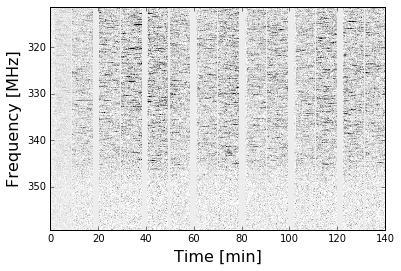

In [309]:
"""
Load Dynamic spectra to do incoherent scintillation analysis
"""

dyn_day1 = np.load('/home/ramain/trials/b1957/b1957-20140613.npy')
#dyn2 = np.load('/home/ramain/trials/b1957/b1957-20140614.npy')
#dyn3 = np.load('/home/ramain/trials/b1957/b1957-20140615.npy')
#dyn4 = np.load('/home/ramain/trials/b1957/b1957-20140616.npy')

dynb = dyn_day1.reshape(-1,1000,8).sum(-1)
#dynb = dynb[:,:750]

%matplotlib inline
plt.imshow(dynb.T, aspect='auto', interpolation='nearest', cmap=cm.Greys,
           vmin=-3000, vmax=18000, extent=[0,dynb.shape[0]/20, 359.25, 311.25])
plt.ylabel('Frequency [MHz]', fontsize=16)
plt.xlabel('Time [min]', fontsize=16)

if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/DynSpec.pdf', dpi=500)

(40, 1000)


(-1, 180)

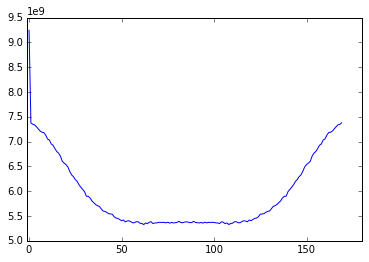

In [310]:
"""
Compute correlation timescale from dynspec

First compute 2D corr to get noise properties
"""
%matplotlib inline
chunk = 170
bgchunk = 40

dyncorr = np.zeros((chunk,dynb.shape[1]))
dynbg = np.zeros((bgchunk,dynb.shape[1]))
tdyncorr = []

# First 40 bins are empty, use this to calibrate noise
dynb_sub = dynb[:bgchunk]

for i in range(bgchunk):
    dyn1 = 1.*dynb_sub
    dyn2 = np.roll(dynb_sub,i,axis=0)
    dynbg[i] = np.mean(dyn1*dyn2, axis=0)

dynb_sub = dynb[410:410+chunk]

print dynbg.shape

for i in range(chunk):
    dyn1 = 1.*dynb_sub
    dyn2 = np.roll(dynb_sub,i,axis=0)
    if i == 0:
        dyncorr[i] = np.mean((dyn1-np.sqrt(dynbg[0])) *( dyn2-np.sqrt(dynbg[0])), axis=0)
    else:
        dyncorr[i] = np.mean(dyn1*dyn2, axis=0)

    tdyncorr.append(i*3)

dyncorr = np.array(dyncorr)    

plt.plot(dyncorr.sum(1))
#plt.plot(dynbg.sum(1))
plt.xlim(-1,180)

348494.180814 6405288.51941


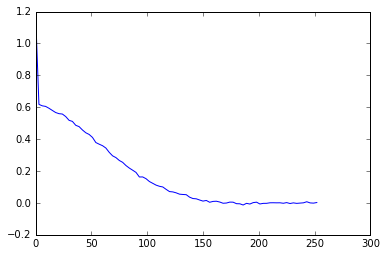

In [311]:
"""
Bins 60-110 look like noise, use them to calibrate

R  =       (p1-p1.mean) * (p2-p2.mean)
           ___________________________
     
     sqrt((sig1^2 - sig1n^2)(sig1^2 - sig1n^2))

"""

chunk = 170

dynclean = 1.*dyncorr
bg_m1 = dynclean[65:105].mean()#axis=0, keepdims=True)
bg_s = dynclean[65:105].std()#axis=0, keepdims=True)
bg_bg = dynbg[0].std()
print bg_bg, bg_s

dynclean = (dynclean-bg_m1) / np.sqrt(dynclean.std()**2.0 - bg_s**2.0)
dyncorr_cal = dynclean[:85].mean(1)
tdyncorr = np.array(tdyncorr)[:85]

plt.plot(tdyncorr, dyncorr_cal)



(2806, 8000)
((76800, 2), 6000, 1200)


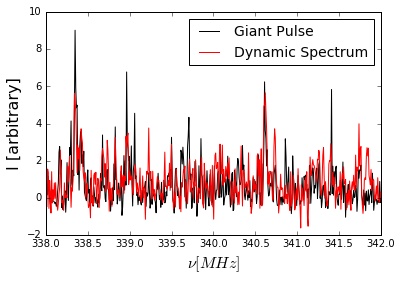

In [291]:
"""
Compute time difference between giant pulse and start of observation

Use this to find part in dynamic spectrum where giant pulse arrives
"""

#t_gp = Time('2014-06-13T06:01:21.91125', precision=5)
t_gp = Time('2014-06-13T07:00:02.13597', precision=5)

t0 = Time('2014-06-13T05:35:46')

dT = t_gp.unix - t0.unix
Tbin = int(dT // 3)
print dyn_day1.shape
GPdyn = dyn_day1[Tbin-5:Tbin+5,:6000].mean(0)

GPR = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (t_gp.isot))
GPL = np.load('/media/drive2/b1957-GPs/LGPs/GP%s.npy' % (t_gp.isot))

GP = np.concatenate((GPR[...,np.newaxis],GPL[...,np.newaxis]),axis=-1)
GP = rechanIm(GP, 6000)


freq = np.linspace(311.5,311.5+48,6001)[:-1]

pulse = (abs(GP[6])**2.0).sum(-1)
bg = (abs(GP[:5])**2.0).mean(0).sum(-1)
GPspec = pulse - bg
GPspec /= GPspec.std()
GPdyn /= GPdyn.std()

%matplotlib inline

plt.plot(freq, GPspec, 'k', label='Giant Pulse')
plt.plot(freq, GPdyn, 'r', label='Dynamic Spectrum')

plt.plot()
plt.legend()
plt.xlabel(r'$\nu [MHz]$', fontsize=16)
plt.ylabel('I [arbitrary]', fontsize=16)
plt.legend(fontsize=14)

# Select subset for plotting
plt.xlim(338,342)

if figures:
    plt.savefig('{0}/SpecComp.pdf'.format(figdir), dpi=500)

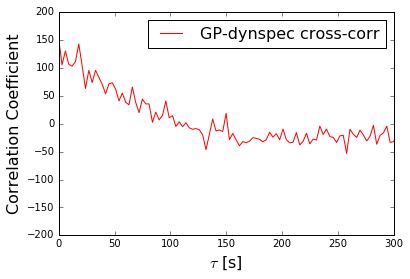

In [294]:
"""
Compute cross correlation between GP spectra and dynamic spectra

It should be maximal at zero lag if the pattern are the same
REQUIRES PREVIOUS STEPS ON DYNSPEC TO GET tdyncorr, dyncorr_cal

FIGURE 4 IN PAPER
"""

N = 400
ccarray = np.zeros(N)
tgpcorr = []
dyn_comp = 1.*dyn1[:,:6000]

j=0
for i in range(-N//2, N//2):

    ctemp = np.mean(GPspec*dyn_comp[Tbin+i])
    ccarray[j] = ctemp
    tgpcorr.append(i*3)
    j+=1

ccarray_p = ccarray - np.median(ccarray[np.isfinite(ccarray)])
#ccarray_p[np.isnan(ccarray)] = 0
#cc_post = ccarray_p[len(ccarray_p)//2::-1][1:] + ccarray_p[len(ccarray_p)//2:]

plt.plot(tgpcorr[len(tgpcorr)//2:], ccarray_p[200:], 'r', label='GP-dynspec cross-corr')
#plt.plot(tdyncorr, dyncorr_cal, 'k', label='dynspec auto-corr')
#plt.plot(ccarray)
plt.ylabel('Correlation Coefficient', fontsize=16)
plt.xlabel(r'$\tau$ [s]', fontsize=16)
plt.xlim(0,300)
plt.legend(fontsize=16)
if figures:
    plt.savefig('{0}DynCorr.pdf'.format(figdir))

In [280]:
"""
Set up pulse lists for de-scattering
"""

b1957GPs = np.loadtxt('/media/drive2/b1957-GPs/gp_RCP.txt', dtype='string')
                      
bT = Time(b1957GPs[:,0], precision=5)
bSN = b1957GPs[:,1].astype('float')
bphase = b1957GPs[:,2].astype('float')

# Pulses used as Green's function measurements
SNcut = 40
bT = bT[bSN > SNcut]
bphase = bphase[bSN > SNcut]
bSN = bSN[bSN > SNcut]

bphase = bphase[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bSN = bSN[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bT = bT[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]

bSN = bSN[abs(bphase-0.8) < 0.1 ]
bT = bT[abs(bphase-0.8) < 0.1 ]
bphase = bphase[abs(bphase-0.8) < 0.1 ]

print bT

Tphase = bT
Tphase = np.delete(Tphase,7)
Tphase = np.delete(Tphase,4)

print Tphase

bT = Time(b1957GPs[:,0], precision=5)
bSN = b1957GPs[:,1].astype('float')
bphase = b1957GPs[:,2].astype('float')

# Pulses for de-scattering
SNcut = 12
bT = bT[bSN > SNcut]
bphase = bphase[bSN > SNcut]
bSN = bSN[bSN > SNcut]

bphase = bphase[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bSN = bSN[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]
bT = bT[abs(bT.unix - Time('2014-06-15T06:30:00').unix) > 18000 ]

bSN = bSN[abs(bphase-0.8) < 0.1 ]
bT = bT[abs(bphase-0.8) < 0.1 ]
bphase = bphase[abs(bphase-0.8) < 0.1 ]

bdT = bT.unix - np.roll(bT.unix, 1)
bsort = np.argsort(bdT)

['2014-06-13T06:01:21.91125' '2014-06-13T06:19:34.04710'
 '2014-06-13T06:49:56.52016' '2014-06-13T07:00:02.13597'
 '2014-06-13T07:00:02.13598' '2014-06-13T07:45:04.81882'
 '2014-06-16T07:09:37.37527' '2014-06-16T07:09:37.37528']
[<Time object: scale='utc' format='isot' value=2014-06-13T06:01:21.91125>
 <Time object: scale='utc' format='isot' value=2014-06-13T06:19:34.04710>
 <Time object: scale='utc' format='isot' value=2014-06-13T06:49:56.52016>
 <Time object: scale='utc' format='isot' value=2014-06-13T07:00:02.13597>
 <Time object: scale='utc' format='isot' value=2014-06-13T07:45:04.81882>
 <Time object: scale='utc' format='isot' value=2014-06-16T07:09:37.37527>]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide


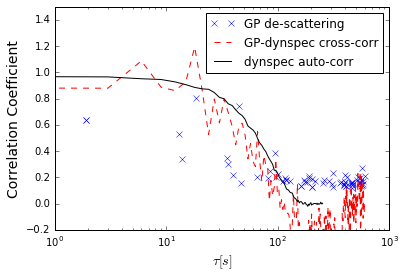

In [331]:
"""
De-scatter all SN > 12 Pulses by S/N > 40 
USING VISIBILITY METHOD

FIGURE in Paper
"""

%matplotlib inline
Tcal = Tphase[0]

cchan = 16*3
fchan = 256*3
timespan = 600 # time to correlate each GP with
IF = slice(0,768)

for j in range(len(Tphase)):

    td = []
    Tcal = Tphase[j]
    
    pb_dT = abs(bT.unix - Tcal.unix)
    T2 = bT[pb_dT < timespan]
    npulses = len(T2)
    pratio = np.zeros(npulses)
    pratio2 = np.zeros(npulses)

    p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (Tcal.isot))[:,IF]
    p1 = np.concatenate((p1,nyq_pad), axis=1)

    for i in range(buff,npulses+buff):
        try:
            p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (T2[i]))[:,IF]
            p2 = np.concatenate((p2,nyq_pad), axis=1)
        except: 
            print("file %s does not exist" % (T2[i]))

        p1prof = (abs(rechannelize(p1,cchan))**2.0).sum(-1)
        p2prof = (abs(rechannelize(p2,cchan))**2.0).sum(-1)

        p1temp = np.roll(rechannelize(p1,cchan), 514-np.argmax(p1prof), axis=0)
        p2temp = np.roll(rechannelize(p2,cchan), 514-np.argmax(p2prof), axis=0)


        p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
        p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
        p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)
        
        p11pcorr = (abs(p22pcorr)**2.0).sum(1)
        p22pcorr = (abs(p22pcorr)**2.0).sum(1)
        p11max = max(p11pcorr) - np.sort(p11pcorr)[-10:-2].mean()
        p22max = max(p22pcorr) - np.sort(p22pcorr)[-10:-2].mean()
        corrnorm = 1.

        pcross = max( (abs(p12pcorr[511:577])**2.0).sum(1) ) - (abs(p12pcorr[50:450])**2.0).sum(1).mean(0) 
    
        pauto = np.sqrt(p11max*p22max)

        pratio[i-buff] = (pcross / pauto)

        td.append(abs(Tcal.unix - Time(T2[i]).unix))
    
    if j==0:
        pr1 = 1*pratio
        td1 = 1.*np.array(td)
    else:
        pr1 = np.concatenate((pr1,pratio))
        td1 = np.concatenate((td1,np.array(td)))


    #plt.plot(np.log10(td), pratio2, 'rx')
    
#plt.plot(np.log10(np.sort(td)), prun[np.argsort(td)] / 3, 'k--', label='mean')
plt.xlim(1,1000)
plt.ylim(-0.2,1.5)
#plt.plot(pratio, 'bx')
plt.plot(td1, pr1, 'bx', label='GP de-scattering')
plt.plot(tgpcorr[len(tgpcorr)//2:], ccarray_p[200:]/120., 'r--', label='GP-dynspec cross-corr')
plt.plot(tdyncorr, dyncorr_cal*(1./0.8**2.0), 'k', label='dynspec auto-corr')
plt.xlabel(r'$\tau [s]$', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xscale('log')
plt.legend()

if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/AllCorr.pdf')

pulse 2014-06-13T06:01:21.91125 de-convolving 18 pulses within 600 seconds


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:115: RuntimeWarning: divide by zero encountered in log10


pulse 2014-06-13T06:19:34.04710 de-convolving 20 pulses within 600 seconds
pulse 2014-06-13T06:49:56.52016 de-convolving 17 pulses within 600 seconds
pulse 2014-06-13T07:00:02.13597 de-convolving 14 pulses within 600 seconds
pulse 2014-06-13T07:45:04.81882 de-convolving 18 pulses within 600 seconds
pulse 2014-06-16T07:09:37.37527 de-convolving 8 pulses within 600 seconds


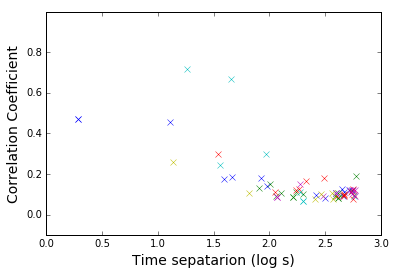

In [378]:
"""
De-scatter all SN > 12 Pulses by S/N > 40 
USING VISIBILITY METHOD

FIGURE in Paper
"""

def rechannelize(pulse, nchan):
    pulse = np.fft.ifft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:  
        pol = pulse.shape[-1]
    else:
        pol = 1
    
    pulse = pulse.reshape(-1,pol)
    
    try:
        pulse = pulse.reshape(-1, nchan, pol)
    except:
        zero_padding = nchan - pulse.shape[0] % nchan
        print("Need to zero pad and reshape")
        pulse = pad(pulse,zero_padding)
        pulse = pulse.reshape(-1, nchan, pol) 

    pulse = np.fft.fft(pulse, axis=1).squeeze()
    
    return pulse


def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse


%matplotlib inline

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles
timespan = 600 # time to correlate each GP with

cratio = pchan // cchan

IF1 = slice(0,768)
IF2 = slice(256,513)
IF3 = slice(511,768)

for j in range(len(Tphase)):
    for IF in [IF1]:
        td = []
        Tcal = Tphase[j]

        pb_dT = abs(bT.unix - Tcal.unix)
        T2 = bT[pb_dT < timespan]
        print("pulse %s de-convolving %s pulses within %s seconds" % (Tcal, len(T2), timespan))
        npulses = len(T2)
        pratio = np.zeros(npulses)
        pratio2 = np.zeros(npulses)

        p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (Tcal.isot))[:,IF]
        p1 = np.concatenate((p1,nyq_pad), axis=1)
        p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
        p1temp = np.roll(rechannelize(p1,cchan), cratio*(514-np.argmax(p1prof)), axis=0)

        for i in range(buff,npulses+buff):
            p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % (T2[i]))[:,IF]
            p2 = np.concatenate((p2,nyq_pad), axis=1)
            
            p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
            p2temp = np.roll(rechannelize(p2,cchan), cratio*(514-np.argmax(p2prof)), axis=0)

            p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
            p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
            p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

            p11pcorr = (abs(p22pcorr)**2.0).sum(1)
            p22pcorr = (abs(p22pcorr)**2.0).sum(1)
            p11max = max(p11pcorr) - np.sort(p11pcorr)[-cratio*10:-cratio*2].mean()
            p22max = max(p22pcorr) - np.sort(p22pcorr)[-cratio*10:-cratio*2].mean()
            corrnorm = 1.

            pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
                abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

            pauto = np.sqrt(p11max*p22max)

            pratio[i-buff] = (pcross / pauto)

            td.append(abs(Tcal.unix - Time(T2[i]).unix))

        #if j==0:
        #    pr1 = 1*pratio
        #    td1 = 1.*np.array(td)
        #else:
        #    pr1 = np.concatenate((pr1,pratio))
        #    td1 = np.concatenate((td1,np.array(td)))
        pr1 = 1*pratio
        td1 = 1.*np.array(td)

        #plt.plot(np.log10(td), pratio2, 'rx')

        #plt.plot(np.log10(np.sort(td)), prun[np.argsort(td)] / 3, 'k--', label='mean')
        plt.xlim(0,3)
        plt.ylim(-0.1,1.0)
        #plt.plot(pratio, 'bx')
        plt.plot(np.log10(td1), pr1, 'x', label='GP de-scattering')
    plt.xlabel('Time sepatarion (log s)', fontsize=14)
    plt.ylabel('Correlation Coefficient', fontsize=14)
    #plt.legend()


(1600,)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


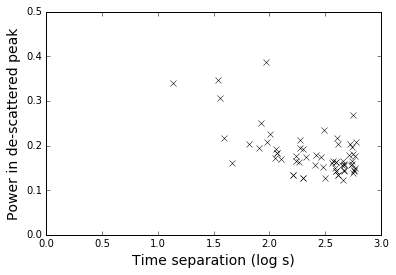

In [332]:
%matplotlib inline

print p11pcorr.shape
#plt.plot(pratio, 'bx')
plt.plot(np.log10(td1), pr1, 'kx')
plt.xlim(0,3)
plt.ylim(0,0.5)
plt.xlabel('Time separation (log s)', fontsize=14)
plt.ylabel('Power in de-scattered peak', fontsize=14)
#plt.savefig('/home/ramain/packages/b1957GiantPulses/DynCorr.pdf')

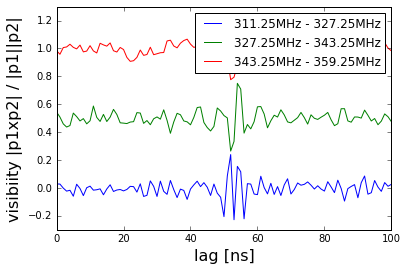

In [343]:
"""
Work with our best pulse pair

Look for voltage correlation a la I-Sheng's method
"""
%matplotlib inline

IF1 = slice(0,256)
IF2 = slice(256,513)
IF3 = slice(511,768)
IFfreq = ([311.25,327.25,343.25,359.25])

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:21.91125'))
p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP%s.npy' % ('2014-06-13T06:01:23.83364'))

p1 = np.concatenate((p1,nyq_pad), axis=-1)
p2 = np.concatenate((p2,nyq_pad), axis=-1)

i = 0
for IF in ([IF1,IF2,IF3]):
    p1temp = dechannelize(p1[49:51,IF])
    p2temp = dechannelize(p2[49:51,IF])
    
    p12pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p2temp))))
    p11pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p1temp))))
    p22pcorr = np.fft.irfft((np.fft.rfft(p2temp) * np.conj( np.fft.rfft(p2temp))))

    corr_norm = np.sqrt(max(abs(p11pcorr))*max(abs(p22pcorr)))

    time_p = np.linspace(0,len(p12pcorr),len(p12pcorr)) * 31.25/3
        
    plt.plot(p12pcorr/corr_norm + i*0.5, label='%sMHz - %sMHz' % (IFfreq[i], IFfreq[i+1]))
    
    i+=1
    
plt.xlabel('lag [bins]', fontsize=16)
plt.ylabel('visibiity |p1xp2| / |p1||p2|', fontsize=16)

plt.xlim(0,100)
plt.ylim(-0.3,1.3)

plt.legend()


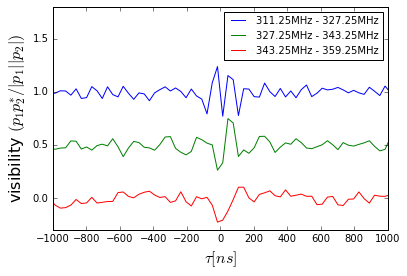

In [377]:
"""
Using above plot, align pulses to ~0 lag, re-correlate, and shift to plot properly

FIGURE IN PAPER
"""

i = 0
for IF in ([IF1,IF2,IF3]):
    p1temp = dechannelize(p1[49:51,IF])
    p2temp = dechannelize(p2[49:51,IF])
    
    p2temp = np.roll(p2temp, 53, )
    
    p12pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p2temp))))
    p11pcorr = np.fft.irfft((np.fft.rfft(p1temp) * np.conj( np.fft.rfft(p1temp))))
    p22pcorr = np.fft.irfft((np.fft.rfft(p2temp) * np.conj( np.fft.rfft(p2temp))))

    corr_norm = np.sqrt(max(abs(p11pcorr))*max(abs(p22pcorr)))

    time_p = np.linspace(-len(p12pcorr)//2,len(p12pcorr)//2,len(p12pcorr)) * 31.25

    p12pcorr_shifted = np.roll(p12pcorr, len(p12pcorr)//2)
    
    plt.plot(time_p, p12pcorr_shifted/corr_norm + 1 - i*0.5, label='%sMHz - %sMHz' % (IFfreq[i], IFfreq[i+1]))
    
    i+=1
    
plt.xlabel(r'$\tau [ns]$', fontsize=16)
plt.ylabel(r'visibility $(p_{1} p_{2}^{*} / |p_{1}||p_{2}|)$', fontsize=16)

plt.xlim(-1000,1000)
plt.ylim(-0.3,1.8)

plt.xticks(np.arange(-1000, 1000+1, 200.0))

plt.legend(fontsize=10)

if figures:
    plt.savefig('/home/ramain/packages/b1957GiantPulses/Visibility.pdf')

In [23]:
"""
Proper Motion 
"""

pmRA=-16.0*np.cos(20*u.deg)*u.arcsec / u.year
pmDec=-25.8*u.arcsec / u.year

PM =  np.sqrt(pmRA**2.0+pmDec**2.0)*np.pi/(3600*180*u.arcsec) * 2*u.kpc

print PM

0.00028954275932 kpc / yr


In [190]:
nchan=16

pulse = np.fft.ifft(p1, axis=1)
# Reshape to channels and keep polarization

print(pulse.shape)

if len(pulse.shape) == 3:  
    pol = pulse.shape[-1]
else:
    pol = 1
    
pulse = pulse.reshape(-1,pol)


try:
    pulse = pulse.reshape(-1, nchan, pol)
except:
    zero_padding = nchan - pulse.shape[0] % nchan
    print("Need to zero pad and reshape")
    pulse = pad(pulse,zero_padding)
    pulse = pulse.reshape(-1, nchan, pol)
    
pulse = np.fft.fft(pulse, axis=1)

(100, 256)


In [196]:
print (pulse.squeeze()).squeeze().shape

(1600, 16)
